In [1]:
import pandas as pd
import numpy as np
import io
import os
import re
import sys
import tensorflow as tf
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data\\goodbooks'
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')

import nlpbasic.textClean as TextProcessing
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as dataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
print(tf.__version__)
pysqldf = lambda q: sqldf(q, globals())

C:\Users\luoyan011\.conda\envs\nlp\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


2.6.0


In [2]:
book_tags = pd.read_csv(os.path.join(root_path, "book_tags.csv"))
books = pd.read_csv(os.path.join(root_path, "books.csv"))
ratings = pd.read_csv(os.path.join(root_path, "ratings.csv"))
tags = pd.read_csv(os.path.join(root_path, "tags.csv"))
to_read = pd.read_csv(os.path.join(root_path, "to_read.csv"))

#load ratings latent variable dataset
user_latent = pd.read_csv(os.path.join(root_path, 'user_latent.csv'))
item_latent = pd.read_csv(os.path.join(root_path, 'item_latent.csv'))

In [3]:
def change_id_from_0(data, column):
    data_copy = data.copy()
    for i in column:
        data_copy[i] = data_copy[i] - 1
    return data_copy

book_tags = change_id_from_0(book_tags, ['goodreads_book_id'])
books = change_id_from_0(books, ['id'])
ratings = change_id_from_0(ratings, ['book_id','user_id'])
to_read = change_id_from_0(to_read, ['book_id','user_id'])
        
user_latent.columns = ['id','u_latent_1','u_latent_2','u_latent_3','u_latent_4',
                       'u_latent_5','u_latent_6','u_latent_7','u_latent_8',
                       'u_latent_9','u_latent_10','u_latent_11','u_latent_12',
                       'u_latent_13','u_latent_14','u_latent_15']
item_latent.columns = ['id','i_latent_1','i_latent_2','i_latent_3','i_latent_4',
                       'i_latent_5','i_latent_6','i_latent_7','i_latent_8',
                       'i_latent_9','i_latent_10','i_latent_11','i_latent_12',
                       'i_latent_13','i_latent_14','i_latent_15']

In [4]:
print('--------------book_tags--------------')
display(book_tags.head(3))
print('--------------books--------------')
display(books.head(3))
print('--------------ratings--------------')
display(ratings.head(3))
print('--------------tags--------------')
display(tags.head(3))
print('--------------to_read--------------')
display(to_read.head(3))
print('--------------user_latent--------------')
display(user_latent.head(3))
print('--------------item_latent--------------')
display(item_latent.head(3))

--------------book_tags--------------


,goodreads_book_id,tag_id,count
0,0,30574,167697
1,0,11305,37174
2,0,11557,34173


--------------books--------------


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,2,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


--------------ratings--------------


,book_id,user_id,rating
0,0,313,5
1,0,438,3
2,0,587,5


--------------tags--------------


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-


--------------to_read--------------


,user_id,book_id
0,0,111
1,0,234
2,0,532


--------------user_latent--------------


,id,u_latent_1,u_latent_2,u_latent_3,u_latent_4,u_latent_5,u_latent_6,u_latent_7,u_latent_8,u_latent_9,u_latent_10,u_latent_11,u_latent_12,u_latent_13,u_latent_14,u_latent_15
0,0,0.199595,-0.108096,0.247037,0.208254,0.106582,-0.123816,0.125920,0.384342,0.611112,-0.349587,-0.031930,-0.156987,0.041728,0.185200,-0.358743
1,1,-0.212097,-0.068822,0.102718,0.252274,-0.133377,-0.093753,-0.558407,0.492150,-0.254548,-0.076484,-0.131823,-0.259838,-0.156847,0.019408,-0.642446
2,2,-0.057435,-0.006853,0.118266,0.120967,-0.020337,-0.095097,-0.039628,0.067750,0.028180,0.038364,0.013028,-0.054933,-0.047005,0.054901,-0.032876


--------------item_latent--------------


,id,i_latent_1,i_latent_2,i_latent_3,i_latent_4,i_latent_5,i_latent_6,i_latent_7,i_latent_8,i_latent_9,i_latent_10,i_latent_11,i_latent_12,i_latent_13,i_latent_14,i_latent_15
0,0,1.900808,0.380494,0.661577,-0.665127,-0.355070,0.904718,0.856841,0.359961,-0.945763,-0.005923,0.378899,-0.479288,-0.702245,-0.751551,-0.541900
1,1,1.694283,0.602090,0.477443,-0.531324,-0.125256,0.900841,1.043496,0.370730,-1.422744,-0.050342,0.366465,-0.751425,-0.551353,-0.573139,-0.660848
2,2,1.265569,0.245617,0.385378,-0.438928,0.333491,0.216258,-0.090325,0.468572,-0.925843,-0.116226,0.675204,-0.455215,-0.768754,-0.879207,-0.654471


In [5]:
user_rating_counts = ratings[['user_id','book_id']].groupby('user_id').agg('count')
user_rating_counts.head(3)

,book_id
user_id,
0,3
1,3
2,2


In [6]:
to_read['rank'] = to_read.groupby('user_id')['book_id'].rank('dense')
to_read.head(10)

,user_id,book_id,rank
0,0,111,1.0
1,0,234,2.0
2,0,532,3.0
3,0,1197,4.0
4,0,1873,5.0
5,0,2057,6.0
6,0,3333,7.0
7,1,3,1.0
8,1,10,2.0
9,1,12,3.0


In [7]:
ratings['rank'] = ratings.groupby('user_id')['book_id'].rank('dense')
ratings.sort_values(by='user_id').head(10)

,book_id,user_id,rating,rank
117889,1179,0,4,1.0
488112,4892,0,3,2.0
625717,6284,0,4,3.0
796318,8033,1,4,1.0
875008,8854,1,5,2.0
959821,9761,1,4,3.0
890007,9013,2,1,1.0
893311,9048,2,1,2.0
326891,3272,3,2,1.0
837459,8463,3,5,3.0


In [23]:
query = """
select A.user_id
    , A.book_id
    , A.rating
    , B.original_title
    , B.authors
    , B.original_publication_year
    , B.language_code
    , B.average_rating
    , B.ratings_count
    , C.book_id as to_read_book_id
    , D.*
    , E.*
from ratings A
left join books B on A.book_id = B.id
left join to_read C on A.user_id = C.user_id and A.rank = C.rank
left join user_latent D on A.user_id = D.id
left join item_latent E on A.book_id = E.id
where B.language_code in ('eng','en-US','en-GB','en-CA')
"""
hybrid_data_base = pysqldf(query)
hybrid_data_base = hybrid_data_base.drop(columns = ['id'])
# hybrid_data_base[['user_id']] = 'u' + hybrid_data_base[['user_id']].astype(str)
# hybrid_data_base[['book_id']] = 'b' + hybrid_data_base[['book_id']].astype(str)
hybrid_data_base[['book_id','user_id']] = hybrid_data_base[['book_id','user_id']].astype(str)
hybrid_data_base.head(3)


,user_id,book_id,rating,original_title,authors,original_publication_year,language_code,average_rating,ratings_count,to_read_book_id,u_latent_1,u_latent_2,u_latent_3,u_latent_4,u_latent_5,u_latent_6,u_latent_7,u_latent_8,u_latent_9,u_latent_10,u_latent_11,u_latent_12,u_latent_13,u_latent_14,u_latent_15,i_latent_1,i_latent_2,i_latent_3,i_latent_4,i_latent_5,i_latent_6,i_latent_7,i_latent_8,i_latent_9,i_latent_10,i_latent_11,i_latent_12,i_latent_13,i_latent_14,i_latent_15
0,313,0,5,The Hunger Games,Suzanne Collins,2008.0,eng,4.34,4780653,10.0,0.565416,0.546839,0.256609,-1.007740,-0.473202,0.049479,0.280110,0.210727,-0.532448,-0.860113,0.335041,0.148334,-0.337264,-0.586449,-0.603003,1.900808,0.380494,0.661577,-0.665127,-0.35507,0.904718,0.856841,0.359961,-0.945763,-0.005923,0.378899,-0.479288,-0.702245,-0.751551,-0.5419
1,438,0,3,The Hunger Games,Suzanne Collins,2008.0,eng,4.34,4780653,120.0,0.811270,0.483355,0.393725,-0.617435,0.300784,0.259413,0.422586,0.058931,-0.734391,-0.499431,-0.014451,0.281844,-0.162854,0.475232,-0.825033,1.900808,0.380494,0.661577,-0.665127,-0.35507,0.904718,0.856841,0.359961,-0.945763,-0.005923,0.378899,-0.479288,-0.702245,-0.751551,-0.5419
2,587,0,5,The Hunger Games,Suzanne Collins,2008.0,eng,4.34,4780653,2115.0,0.683785,0.593587,0.700573,-0.508013,-1.182165,-0.424068,0.672739,-0.196326,-0.031572,-0.659620,-0.111626,-0.663243,-0.828182,0.270393,-0.394489,1.900808,0.380494,0.661577,-0.665127,-0.35507,0.904718,0.856841,0.359961,-0.945763,-0.005923,0.378899,-0.479288,-0.702245,-0.751551,-0.5419


In [18]:
print(hybrid_data_base.shape)
print(ratings.shape)

(981756, 42)
(981756, 4)


In [22]:
hybrid_data_base.columns

Index(['user_id', 'book_id', 'rating', 'original_title', 'authors',
       'original_publication_year', 'language_code', 'average_rating',
       'ratings_count', 'to_read_book_id', 'u_latent_1', 'u_latent_2',
       'u_latent_3', 'u_latent_4', 'u_latent_5', 'u_latent_6', 'u_latent_7',
       'u_latent_8', 'u_latent_9', 'u_latent_10', 'u_latent_11', 'u_latent_12',
       'u_latent_13', 'u_latent_14', 'u_latent_15', 'i_latent_1', 'i_latent_2',
       'i_latent_3', 'i_latent_4', 'i_latent_5', 'i_latent_6', 'i_latent_7',
       'i_latent_8', 'i_latent_9', 'i_latent_10', 'i_latent_11', 'i_latent_12',
       'i_latent_13', 'i_latent_14', 'i_latent_15'],
      dtype='object')

## Data Embedding Processing (Discontinued)

In [46]:
import tensorflow_hub as hub

In [78]:
factor_columns = ['u_latent_{}'.format(i for i in range(15))] + ['i_latent_{}'.format(i for i in range(15))]
non_factor_columns = ['book_id', 'original_title', 'authors', 'original_publication_year',  
                      'rating', 'average_rating', 'ratings_count', 'to_read_book_id']
label_columns = 'to_read_book_id'

In [79]:

number_of_book_ids = len(hybrid_data_base.book_id.unique())
print('number_of_book_ids:', number_of_book_ids)
number_of_authors = len(hybrid_data_base.authors.unique())
print('number_of_authors:', number_of_authors)


number_of_book_ids: 10000
number_of_authors: 4664


In [80]:
def create_feature_columns(args):
    # create book_id feature column
    book_id_column = tf.feature_column.categorical_column_with_hash_bucket(
        key = 'book_id',
        hash_bucket_size = number_of_book_ids
    )
    # embed book_id into a lower dimensional representation
    embedded_book_columns = tf.feature_column.embedding_column(
        categorical_column = book_id_column,
        dimension = args['book_id_embedding_dimensions']
    )
    
    # create title feature column usng TF Hub
    embedded_title_column = hub.text_embedding_column_v2(
        key = 'oriinal_title',
        module_path = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2",
        trainable = False
    )
    
    #create author feature column
    author_column = tf.feature_column.categorical_column_with_hash_bucket(
        key = 'authors',
        hash_bucket_size = number_of_authors + 1
    )
    # embed author into a lower dimensional representative
    embedded_author_column = tf.feature_column.embedding_column(
        categorical_column = author_column,
        dimension = args['author_embedding_dimensions']
    )
    
    #create original publication year boundaries list 
    original_publication_year_boundaries = [-500, 500, 1000, 1500, 1600, 1700, 1800, 1900, 1950, 
                                            1960, 1970, 1980, 1990, 2000, 2005, 2010, 2015]
    
    # create original_publication_year feature column using raw data
    original_publication_year_column = tf.feature_column.numeric_column(
        key = 'original_publication_year'
    )
    
    #create original_publication_year feature column using boundaries list
    original_publication_year_bucketized = tf.feature_column.bucketized_column(
        source_column = original_publication_year_column,
        boundaries = original_publication_year_boundaries
    )
    
    #create user and item factor feature columns from trained WALS model
    user_factors = [tf.feature_column.numeric_column(key = 'u_latent_' + str(i)) for i in range(15)]
    item_factors = [tf.feature_column.numeric_column(key = 'i_latent_' + str(i)) for i in range(15)]
    rating_columns = tf.feature_column.numeric_column(key = 'rating')
    average_rating_columns = tf.feature_column.numeric_column(key = 'average_rating')
    ratings_count_columns = tf.feature_column.numeric_column(key = 'ratings_count')

    feature_columns = [
        embedded_book_columns,
        embedded_title_column,
        embedded_author_column,
        original_publication_year_bucketized,
        rating_columns,
        average_rating_columns,
        ratings_count_columns
    ] + user_factors + item_factors 
    return feature_columns

In [81]:
feature_para = {
    'author_embedding_dimensions' : 500,
    'book_id_embedding_dimensions' : 1000
}
create_feature_columns(feature_para)

[EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='book_id', hash_bucket_size=10000, dtype=tf.string), dimension=1000, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000002754C110100>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 _TextEmbeddingColumnV2(key='oriinal_title', module_path='https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2', output_key=None, trainable=False),
 EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='authors', hash_bucket_size=4665, dtype=tf.string), dimension=500, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x000002754C110970>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 BucketizedColumn(source_column=NumericColumn(key='original_publication_year', shape=(1,), default_value=None, dtype=tf.float32, normaliz

## Tensorflow-Recommender

In [9]:
hybrid_data_base.head(3)


,user_id,book_id,rating,original_title,authors,original_publication_year,language_code,average_rating,ratings_count,to_read_book_id,u_latent_1,u_latent_2,u_latent_3,u_latent_4,u_latent_5,u_latent_6,u_latent_7,u_latent_8,u_latent_9,u_latent_10,u_latent_11,u_latent_12,u_latent_13,u_latent_14,u_latent_15,i_latent_1,i_latent_2,i_latent_3,i_latent_4,i_latent_5,i_latent_6,i_latent_7,i_latent_8,i_latent_9,i_latent_10,i_latent_11,i_latent_12,i_latent_13,i_latent_14,i_latent_15
0,313,0,5,The Hunger Games,Suzanne Collins,2008.0,eng,4.34,4780653,10.0,0.565416,0.546839,0.256609,-1.007740,-0.473202,0.049479,0.280110,0.210727,-0.532448,-0.860113,0.335041,0.148334,-0.337264,-0.586449,-0.603003,1.900808,0.380494,0.661577,-0.665127,-0.35507,0.904718,0.856841,0.359961,-0.945763,-0.005923,0.378899,-0.479288,-0.702245,-0.751551,-0.5419
1,438,0,3,The Hunger Games,Suzanne Collins,2008.0,eng,4.34,4780653,120.0,0.811270,0.483355,0.393725,-0.617435,0.300784,0.259413,0.422586,0.058931,-0.734391,-0.499431,-0.014451,0.281844,-0.162854,0.475232,-0.825033,1.900808,0.380494,0.661577,-0.665127,-0.35507,0.904718,0.856841,0.359961,-0.945763,-0.005923,0.378899,-0.479288,-0.702245,-0.751551,-0.5419
2,587,0,5,The Hunger Games,Suzanne Collins,2008.0,eng,4.34,4780653,2115.0,0.683785,0.593587,0.700573,-0.508013,-1.182165,-0.424068,0.672739,-0.196326,-0.031572,-0.659620,-0.111626,-0.663243,-0.828182,0.270393,-0.394489,1.900808,0.380494,0.661577,-0.665127,-0.35507,0.904718,0.856841,0.359961,-0.945763,-0.005923,0.378899,-0.479288,-0.702245,-0.751551,-0.5419


In [25]:
hybrid_data_base.dtypes

user_id                       object
book_id                       object
rating                         int64
original_title                object
authors                       object
original_publication_year    float64
language_code                 object
average_rating               float64
ratings_count                  int64
to_read_book_id              float64
u_latent_1                   float64
u_latent_2                   float64
u_latent_3                   float64
u_latent_4                   float64
u_latent_5                   float64
u_latent_6                   float64
u_latent_7                   float64
u_latent_8                   float64
u_latent_9                   float64
u_latent_10                  float64
u_latent_11                  float64
u_latent_12                  float64
u_latent_13                  float64
u_latent_14                  float64
u_latent_15                  float64
i_latent_1                   float64
i_latent_2                   float64
i

In [11]:
# ratings_df = hybrid_data_base[['user_id','book_id']].drop_duplicates()
# users_df = ratings_df['user_id'].unique()
# books_df = ratings_df['book_id'].unique()

# ratings_ds = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
# books_ds = tf.data.Dataset.from_tensor_slices(books_df)

# tf.random.set_seed(42)
# shuffled = ratings_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

# train = shuffled.take(60_000)
# test = shuffled.skip(60_000).take(20_000)

In [42]:
### define interactions data and user data

### interactions 
### here we create a reference table of the user , item, and quantity purchased
interactions_dict = hybrid_data_base[['user_id', 'book_id']]#.groupby(['user_id', 'book_id'])[ 'rating'].sum().reset_index()

## we tansform the table inta a dictionary , which then we feed into tensor slices
# this step is crucial as this will be the type of data fed into the embedding layers
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

## we do similar step for item, where this is the reference table for items to be recommended
items_dict = hybrid_data_base[['book_id']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

## map the features in interactions and items to an identifier that we will use throught the embedding layers
## do it for all the items in interaction and item table
## you may often get itemtype error, so that is why here i am casting the quantity type as float to ensure consistency
interactions = interactions.map(lambda x: {
    'user_id' : x['user_id'], 
    'book_id' : x['book_id'] 
#     'rating' : float(x['rating']),

})

items = items.map(lambda x: x['book_id'])

In [17]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))


In [47]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(60_000)
test = shuffled.skip(60_000).take(20_000)

In [48]:
test

<TakeDataset shapes: {user_id: (), book_id: ()}, types: {user_id: tf.string, book_id: tf.string}>

**Ranking and Retrieval**

In [20]:
from typing import Dict, Text
import tensorflow_recommenders as tfrs

In [43]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
        super().__init__()
        
        ### Candidate model (item)
        ### This is Keras preprocessing layers to first convert user ids to integers, 
        ### and then convert those to user embeddings via an Embedding layer. 
        ### We use the list of unique user ids we computed earlier as a vocabulary:
        item_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                        ])
        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model
            
        ### Query model (users)    
        user_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # We add an additional embedding to account for unknown tokens.
                                        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                        ])
        self.user_model: tf.keras.Model = user_model
        
        ### for retrieval model. we take top-k accuracy as metrics
        metrics = tfrs.metrics.FactorizedTopK(
                                            candidates=items.batch(128).map(item_model)
        )
        task = tfrs.tasks.Retrieval(
                                    metrics=metrics
                                    )
       
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        book_embeddings = self.item_model(features["book_id"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, book_embeddings)

In [53]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32

## we pass the model, which is the same model we created in the query and candidate tower, into the model
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
8/8 [==============================] - 16s 2s/step - factorized_top_k/top_1_categorical_accuracy: 3.3333e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0039 - factorized_top_k/top_10_categorical_accuracy: 0.0085 - factorized_top_k/top_50_categorical_accuracy: 0.0404 - factorized_top_k/top_100_categorical_accuracy: 0.0753 - loss: 61981.7630 - regularization_loss: 0.0000e+00 - total_loss: 61981.7630
Epoch 2/10
8/8 [==============================] - 15s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0091 - factorized_top_k/top_5_categorical_accuracy: 0.0457 - factorized_top_k/top_10_categorical_accuracy: 0.0791 - factorized_top_k/top_50_categorical_accuracy: 0.2460 - factorized_top_k/top_100_categorical_accuracy: 0.3770 - loss: 59479.7665 - regularization_loss: 0.0000e+00 - total_loss: 59479.7665
Epoch 3/10
8/8 [==============================] - 15s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0314 - factorized_top_k/top_5_categorical_accuracy: 0.107

{'factorized_top_k/top_1_categorical_accuracy': 0.0006000000284984708,
 'factorized_top_k/top_5_categorical_accuracy': 0.015699999406933784,
 'factorized_top_k/top_10_categorical_accuracy': 0.04084999859333038,
 'factorized_top_k/top_50_categorical_accuracy': 0.1813499927520752,
 'factorized_top_k/top_100_categorical_accuracy': 0.30320000648498535,
 'loss': 29743.26171875,
 'regularization_loss': 0,
 'total_loss': 29743.26171875}

In [54]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 4s 867ms/step - factorized_top_k/top_1_categorical_accuracy: 6.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0157 - factorized_top_k/top_10_categorical_accuracy: 0.0408 - factorized_top_k/top_50_categorical_accuracy: 0.1813 - factorized_top_k/top_100_categorical_accuracy: 0.3032 - loss: 32273.5410 - regularization_loss: 0.0000e+00 - total_loss: 32273.5410


{'factorized_top_k/top_1_categorical_accuracy': 0.0006000000284984708,
 'factorized_top_k/top_5_categorical_accuracy': 0.015699999406933784,
 'factorized_top_k/top_10_categorical_accuracy': 0.04084999859333038,
 'factorized_top_k/top_50_categorical_accuracy': 0.1813499927520752,
 'factorized_top_k/top_100_categorical_accuracy': 0.30320000648498535,
 'loss': 29743.26171875,
 'regularization_loss': 0,
 'total_loss': 29743.26171875}

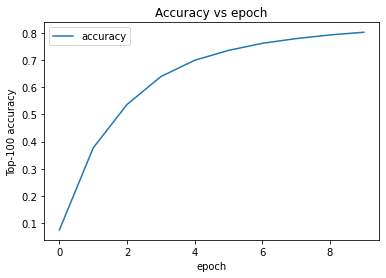

In [56]:
# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [60]:
items.batch(100).map(model.item_model)

<MapDataset shapes: (None, 32), types: tf.float32>

In [58]:
model.item_model

In [59]:
items.batch(100)

<BatchDataset shapes: (None,), types: tf.string>

In [61]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k = 100)
# recommends movies out of the entire movies dataset.
index.index(items.batch(100).map(model.item_model), items)

# Get recommendations.
j = str(40)
_, titles = index(tf.constant([j]))
print(f"Recommendations for user %s: {titles[0]}" %(j))

ValueError: Attempt to convert a value (<MapDataset shapes: (None, 32), types: tf.float32>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>) to a Tensor.